# AMLT Lab#1

## Table of content

- [AMLT Lab#1](#AMLT-Lab1)
  - [Table of content](#table-of-content)
  - [Imports](#imports)
  - [Data](#data)
  - [Models](#models)
    - [ARIMA](#arima-model)
      - [Hyperparams](#hyperparams1)
      - [Model](#model1)
    - [LSTM](#lstm-model)
      - [Hyperparams](#hyperparams2)
      - [Model](#model2)
      - [Init](#init)
  - [Results](#results)
    - [ARIMA](#arima)
    - [LSTM](#lstm)
  - [Model comparation](#models-comparation)

## Imports

In [1]:
import keras
import warnings
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from itertools import product
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

## Data

In [2]:
df = pd.read_csv('Rain.csv',';', index_col=['Date'], parse_dates=['Date'], dayfirst=True, encoding='cp1251')
df.rename({'Specific Humidity': 'Volume'}, axis='columns', inplace=True)
df = df[['Volume']]
df_LSTM = df.copy()
df.head(3)

,Volume
Date,
2000-01-01,8.06
2000-02-01,8.73
2000-03-01,8.48


In [3]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# trajectory matrix

d1 = series_to_supervised(df_LSTM, n_in=5, n_out=7, dropnan=True)
d1

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
Date,,,,,,,,,,,,
2000-06-01,8.06,8.73,8.48,13.79,17.40,19.53,18.80,18.86,18.43,16.72,12.02,7.39
2000-07-01,8.73,8.48,13.79,17.40,19.53,18.80,18.86,18.43,16.72,12.02,7.39,8.06
2000-08-01,8.48,13.79,17.40,19.53,18.80,18.86,18.43,16.72,12.02,7.39,8.06,7.57
2000-09-01,13.79,17.40,19.53,18.80,18.86,18.43,16.72,12.02,7.39,8.06,7.57,11.29
2000-10-01,17.40,19.53,18.80,18.86,18.43,16.72,12.02,7.39,8.06,7.57,11.29,12.27
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01,19.78,18.13,15.62,14.10,10.62,9.28,10.50,13.31,16.17,19.78,20.26,20.08
2020-03-01,18.13,15.62,14.10,10.62,9.28,10.50,13.31,16.17,19.78,20.26,20.08,19.71
2020-04-01,15.62,14.10,10.62,9.28,10.50,13.31,16.17,19.78,20.26,20.08,19.71,18.43


Text(0.5, 0, 'Months since January 2000')

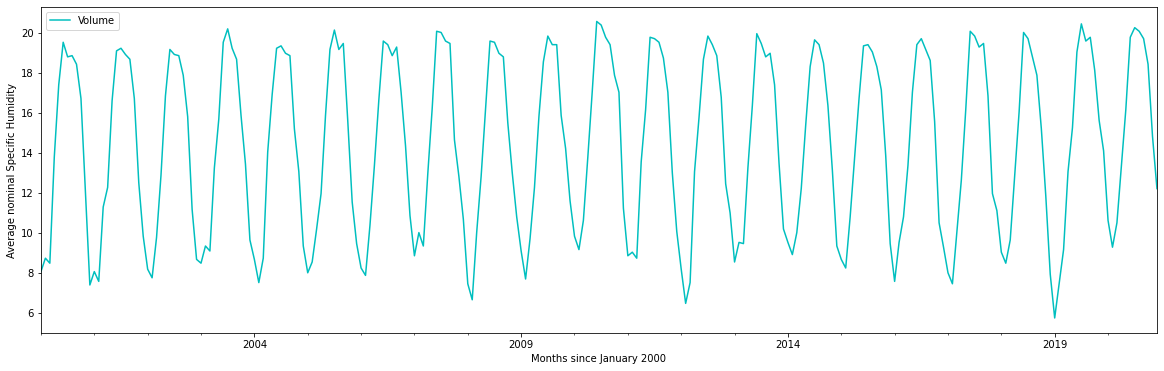

In [4]:
df.plot(figsize = (20,6), color='c')
plt.ylabel('Average nominal Specific Humidity')
plt.xlabel('Months since January 2000')

Dickey-Fuller test: p=0.000261


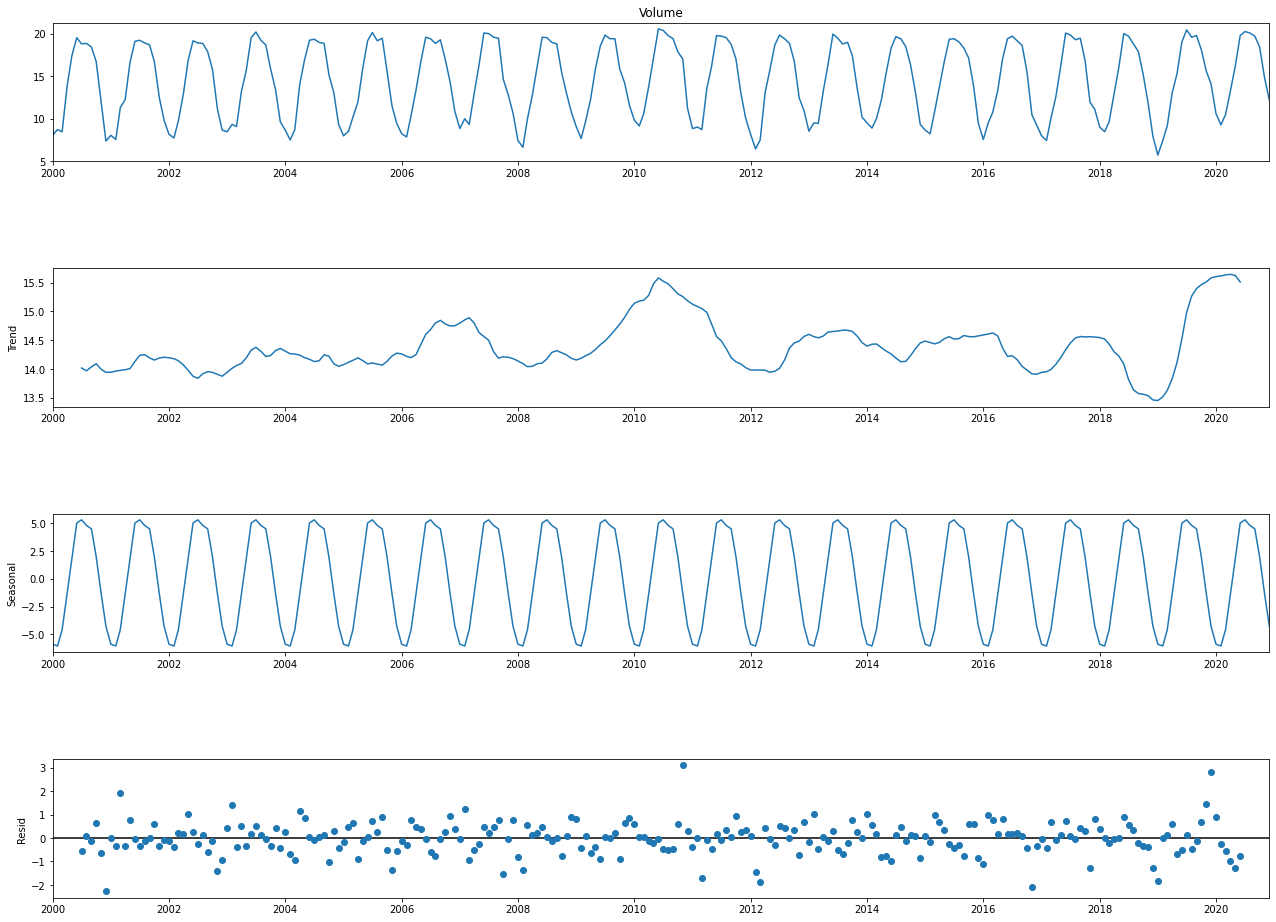

In [5]:
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(df.Volume)[1])
sm.tsa.seasonal_decompose(df.Volume).plot().set_size_inches((20, 15))
plt.show()

## Models

### ARIMA model

#### Hyperparams1

In [6]:
ps = range(0, 6)   # 5 
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


#### Model1

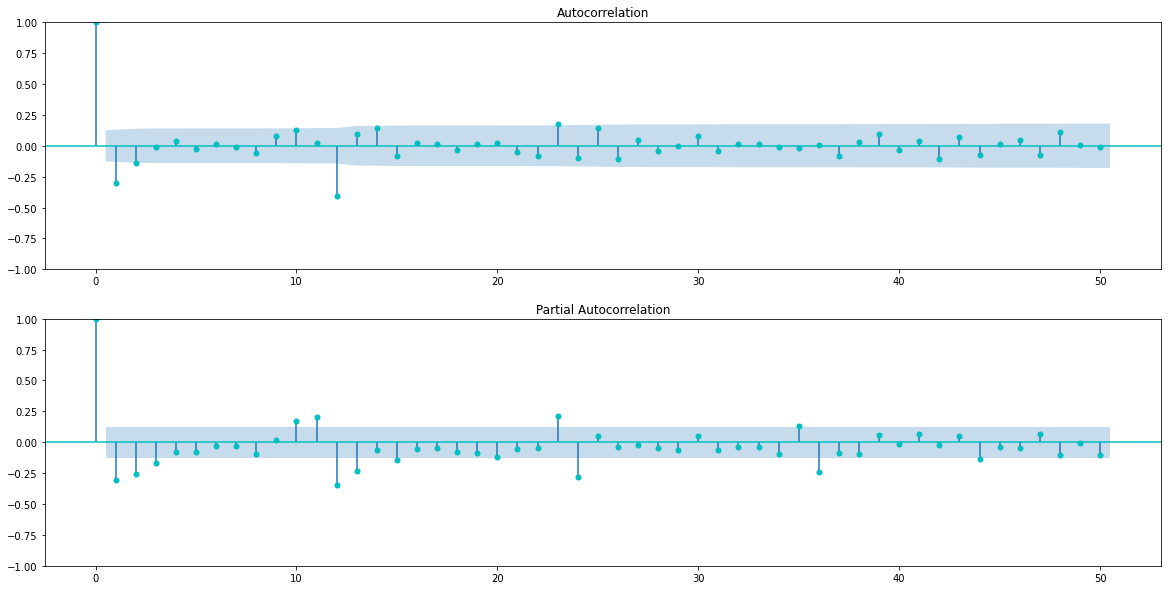

In [7]:
sm.tsa.seasonal_decompose(df.Volume)
sm.tsa.stattools.adfuller(df.Volume)[1]
df['Volume_box'], lmbda = stats.boxcox(df.Volume)

sm.tsa.stattools.adfuller(df.Volume_box)[1]

df['Volume_box_diff'] = df.Volume_box - df.Volume_box.shift(12)
sm.tsa.seasonal_decompose(df.Volume_box_diff[12:])
sm.tsa.stattools.adfuller(df.Volume_box_diff[12:])[1]

df['Volume_box_diff2'] = df.Volume_box_diff - df.Volume_box_diff.shift(1)
sm.tsa.seasonal_decompose(df.Volume_box_diff2[13:])
sm.tsa.stattools.adfuller(df.Volume_box_diff2[13:])[1]

plt.figure(figsize=(20,10))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Volume_box_diff2[13:].values.squeeze(), lags=50, ax=ax, color='c')

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Volume_box_diff2[13:].values.squeeze(), lags=50, ax=ax, color='c')

plt.show()

In [8]:
results = []
best_aic = float("inf")

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df.Volume_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

     parameters         aic
6  (5, 3, 1, 0)  701.556566
5  (1, 2, 1, 0)  702.660721
4  (0, 5, 1, 0)  709.177772
3  (0, 2, 1, 0)  711.867649
2  (0, 1, 1, 0)  713.252316


### LSTM model

#### Hyperparams2

In [19]:
n_lag = 36
n_seq = 48
n_test = 1
n_epochs = 30
n_batch = 1
n_neurons =  8

#### Model2

In [10]:
# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = keras.models.Sequential()
    
    # stateful = True - keep state in memory;
    
    model.add(keras.layers.LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(keras.layers.Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

#### Init

In [20]:
scaler, train, test = prepare_data(df_LSTM, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(df_LSTM, forecasts, scaler, n_test+2)

0
150/150 [==============================] - 2s 6ms/step - loss: 0.1551 - val_loss: 0.1165
1
150/150 [==============================] - 1s 3ms/step - loss: 0.0850 - val_loss: 0.0577
2
150/150 [==============================] - 1s 4ms/step - loss: 0.0474 - val_loss: 0.0390
3
150/150 [==============================] - 1s 4ms/step - loss: 0.0376 - val_loss: 0.0362
4
150/150 [==============================] - 1s 4ms/step - loss: 0.0360 - val_loss: 0.0359
5
150/150 [==============================] - 1s 4ms/step - loss: 0.0354 - val_loss: 0.0357
6
150/150 [==============================] - 1s 4ms/step - loss: 0.0351 - val_loss: 0.0355
7
150/150 [==============================] - 1s 4ms/step - loss: 0.0347 - val_loss: 0.0353
8
150/150 [==============================] - 1s 4ms/step - loss: 0.0343 - val_loss: 0.0351
9
150/150 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0350
10
150/150 [==============================] - 0s 3ms/step - loss: 0.0336 - val_loss: 0.034

## Results

### ARIMA

In [12]:
print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print(best_model.summary())

Student test: p=0.691528
Dickey-Fuller test: p=0.0000000000000000000000000
                                      SARIMAX Results                                      
Dep. Variable:                          Volume_box   No. Observations:                  252
Model:             SARIMAX(5, 1, 3)x(1, 1, [], 12)   Log Likelihood                -340.778
Date:                             Fri, 14 Oct 2022   AIC                            701.557
Time:                                     16:20:29   BIC                            736.321
Sample:                                 01-01-2000   HQIC                           715.566
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3881      0.06

Text(0, 0.5, 'dfe')

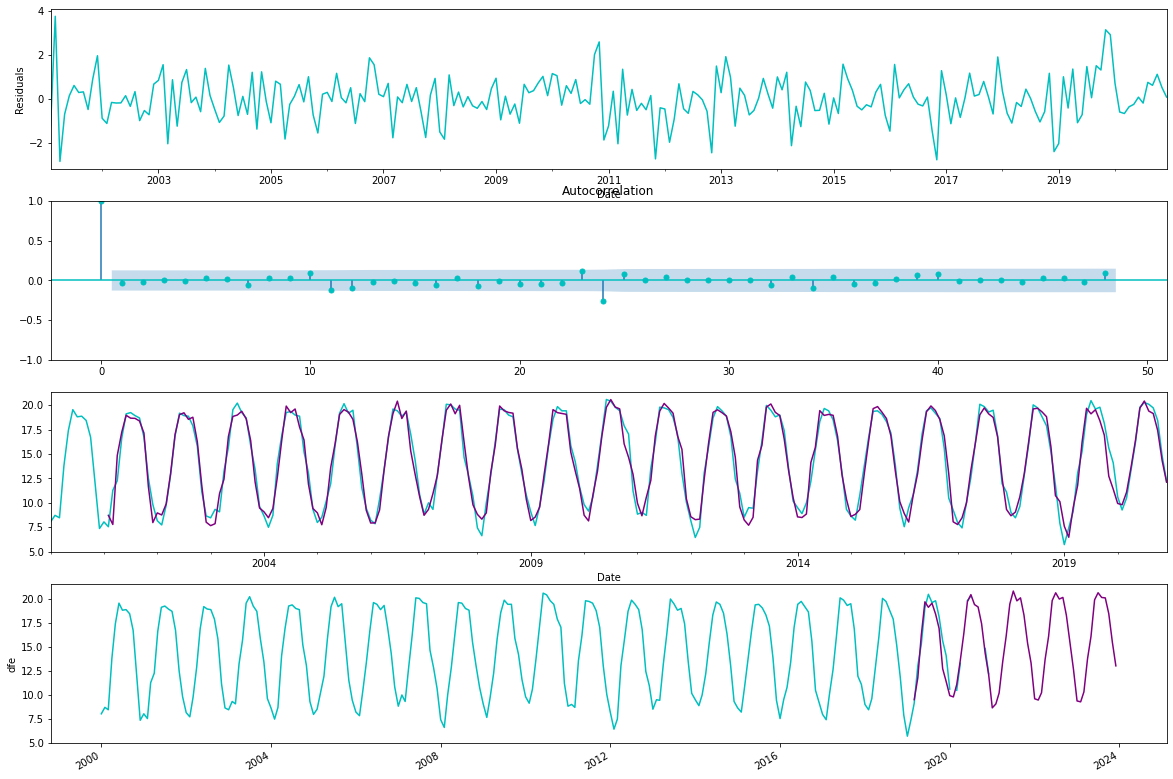

In [13]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
df['model'] = invboxcox(best_model.fittedvalues, lmbda)

plt.figure(figsize = (20,15))
plt.subplot(411)
best_model.resid[13:].plot(color='c')
plt.ylabel('Residuals')

ax = plt.subplot(412)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax, color='c')

plt.subplot(413)
df.Volume.plot(color='c')
df.model[13:].plot(color='purple')

df2 = df[['Volume']]
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,48)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=230, end=290), lmbda)

plt.subplot(414)
df2.Volume.plot(color='c')
df2.forecast.plot(color='purple')
plt.ylabel('dfe')

### LSTM

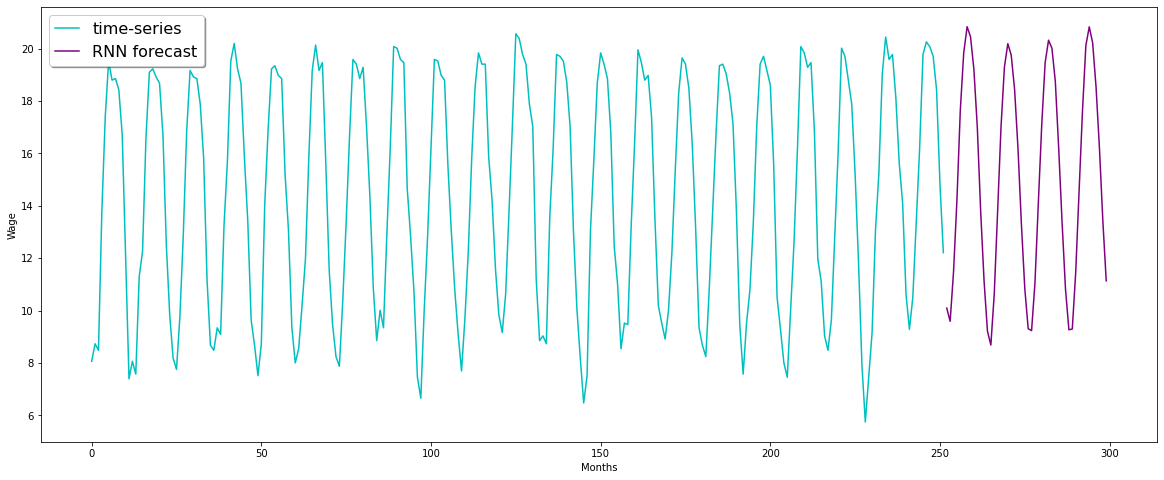

In [27]:
# visualize

fig=plt.figure(figsize=(20,8))
plt.plot(df_LSTM.values[:], color='c')
off_s = len(df_LSTM) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [df_LSTM.values[off_s]] + forecasts[-1]
yaxis = [x-8 for x in yaxis[1:]]
plt.plot(xaxis[1:], yaxis, color='purple')

# print([x-1 for x in xaxis[1:]])
plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()

[0.028541047126054764] [0.03286527842283249]


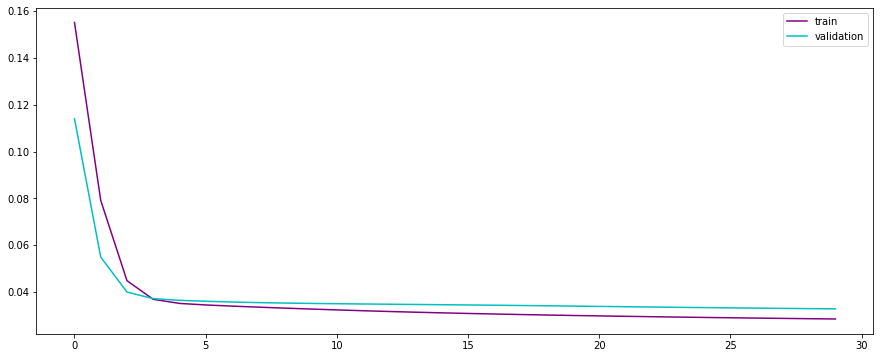

In [15]:
# Loss functions for val and train sets
plt.figure(figsize=(15, 6))
plt.plot(history_loss, 'r',label='train', color='purple')
plt.plot(history_val_loss,label='validation', color='c')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

## Models comparation

In [22]:
y_true = df.Volume.tolist()[192:241]
y_pred_arima = df.model.tolist()[192:241]
y_pred_lstm = df2.forecast.tolist()[241:288]

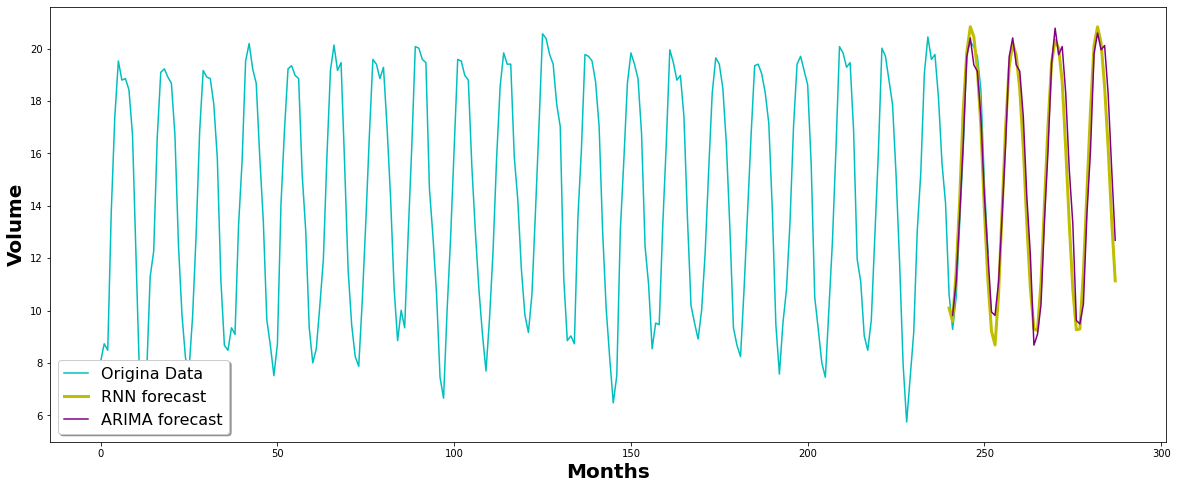

In [25]:
# visualize

fig=plt.figure(figsize=(20,8))

plt.plot(df_LSTM.values[:], color='c')
off_s = len(df_LSTM) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [df_LSTM.values[off_s]] + forecasts[-1]
yaxis = [x-8 for x in yaxis[1:]]
plt.plot([x-12 for x in xaxis[1:]], yaxis, color='y', linewidth=3)

plt.plot([x-12 for x in xaxis[2:]], df2.forecast.tolist()[241:288], color='purple')
plt.ylabel('Volume', fontsize=20, fontweight='bold')
plt.xlabel('Months', fontsize=20, fontweight='bold')

plt.legend(('Origina Data', 'RNN forecast', 'ARIMA forecast'),
           shadow=True, loc='lower left', handlelength=1.5, fontsize=16)

In [26]:
result_tab = PrettyTable()
result_tab.field_names = ["Model", "r2", "MAPE", "MSE"]
result_tab.add_row(["ARIMA", r2_score(y_true, y_pred_arima), mean_absolute_percentage_error(y_true, y_pred_arima), mean_squared_error(y_true, y_pred_arima)])
result_tab.add_row(["LSTM", r2_score(yaxis[1:], y_pred_lstm), mean_absolute_percentage_error(yaxis[1:], y_pred_lstm), mean_squared_error(yaxis[1:], y_pred_lstm)])
print(result_tab)

+-------+--------------------+---------------------+--------------------+
| Model |         r2         |         MAPE        |        MSE         |
+-------+--------------------+---------------------+--------------------+
| ARIMA | 0.9412241275898434 | 0.07203397691407898 | 1.2050382164110713 |
|  LSTM | 0.9353122478933994 | 0.05969633332949128 | 1.0628187523149837 |
+-------+--------------------+---------------------+--------------------+


## Conclusion:
There is **no fundamental difference** in the results between ARIMA and LSTM. Depending on the randomness, I got results for LSTM from ***84% to 96%*** for the r^2 metric. In some cases, with a successful set of circumstances, the LSTM model can increase efficiency, but the cost of multiple iterations to fine-tune the model, in my opinion, **is inappropriate, since ARIMA immediately gives almost the same result**.